# 1. Installing Dependencies

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import keras
from keras.preprocessing import image
from keras import applications as keras_applications
!pip install keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils


/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv


# Data Preprocess

In [7]:
os.system('tar -xf /kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz');
data = pd.read_csv('fer2013/fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [8]:
data.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [9]:
train_data = data[data.Usage=='Training']
val_data = data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']

In [10]:
train_data.shape, val_data.shape, test_data.shape

((28709, 3), (3589, 3), (3589, 3))

In [11]:
import collections
import imblearn
oversampler = imblearn.over_sampling.RandomOverSampler()

In [12]:
collections.Counter(train_data.emotion)

Counter({0: 3995, 2: 4097, 4: 4830, 6: 4965, 3: 7215, 5: 3171, 1: 436})

In [13]:
from keras.utils import to_categorical

x_train, y_train = oversampler.fit_resample(train_data.pixels.values.reshape(-1,1),train_data.emotion.values)

# x_train = train_data.pixels.values.reshape(-1,1)
# y_train = train_data.emotion.values

x_val = val_data.pixels.values.reshape(-1,1)
y_val = val_data.emotion.values

x_test = test_data.pixels.values.reshape(-1,1)
y_test = test_data.emotion.values

In [14]:
collections.Counter(y_train)

Counter({0: 7215, 2: 7215, 4: 7215, 6: 7215, 3: 7215, 5: 7215, 1: 7215})

In [15]:
x_train = list(x_train)
x_val   = list(x_val)
x_test  = list(x_test)

for i,item in enumerate(x_train):
    x_train[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_val):
    x_val[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_test):
    x_test[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
    
x_train = np.vstack(x_train).reshape(-1,48,48,1)
x_val = np.vstack(x_val).reshape(-1,48,48,1)
x_test = np.vstack(x_test).reshape(-1,48,48,1)

In [16]:
y_train = to_categorical(y_train,num_classes=7)
y_val   = to_categorical(y_val  ,num_classes=7)
y_test  = to_categorical(y_test ,num_classes=7)

In [17]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [18]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [19]:
train_sequence = data_sequence(x_train,y_train,batch_size=16,target_dim=(224,224),n_classes=7,shuffle=False)
feature,lable = train_sequence.__getitem__(0)

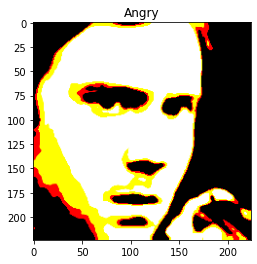

In [20]:
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

import matplotlib.pyplot as plt
plt.imshow(feature[0,:,:,:])
plt.title(emotion_dict[np.argmax(lable[0])]);

# Model

In [21]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
vggface.summary()

94699520/94694792 [==============================] - 1s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________

In [22]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

# model = Sequential([vggface,
#                     Flatten(),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(128, activation='relu'),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                 7

In [23]:
train_sequence = data_sequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(x_val,  y_val,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

### Train Top Layers

In [24]:
model.compile(optimizer = keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(generator = train_sequence,
                           validation_data = val_sequence,
                           epochs = 20)

Epoch 1/20
789/789 [==============================] - 165s 209ms/step - loss: 1.2549 - accuracy: 0.5725 - val_loss: 1.0766 - val_accuracy: 0.6021
Epoch 2/20
789/789 [==============================] - 163s 207ms/step - loss: 0.8682 - accuracy: 0.6752 - val_loss: 1.0219 - val_accuracy: 0.6161
Epoch 3/20
789/789 [==============================] - 160s 203ms/step - loss: 0.7543 - accuracy: 0.7220 - val_loss: 1.0246 - val_accuracy: 0.6297
Epoch 4/20
789/789 [==============================] - 161s 204ms/step - loss: 0.6617 - accuracy: 0.7595 - val_loss: 1.0399 - val_accuracy: 0.6214
Epoch 5/20
789/789 [==============================] - 159s 202ms/step - loss: 0.5887 - accuracy: 0.7870 - val_loss: 1.0570 - val_accuracy: 0.6336
Epoch 6/20
789/789 [==============================] - 159s 201ms/step - loss: 0.5281 - accuracy: 0.8135 - val_loss: 1.0818 - val_accuracy: 0.6345
Epoch 7/20
789/789 [==============================] - 161s 204ms/step - loss: 0.4786 - accuracy: 0.8320 - val_loss: 1.0806 -

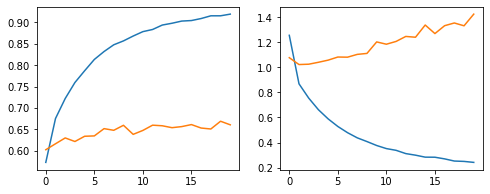

In [25]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### Finetune All
lr=1e-4

In [26]:
for layer in model.layers[0].layers:
    if 'bn' not in layer.name:
        layer.trainable = True

In [27]:
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = model.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)

Epoch 1/10
789/789 [==============================] - 159s 202ms/step - loss: 0.1686 - accuracy: 0.9429 - val_loss: 1.4463 - val_accuracy: 0.6724
Epoch 2/10
789/789 [==============================] - 157s 200ms/step - loss: 0.1361 - accuracy: 0.9529 - val_loss: 1.4716 - val_accuracy: 0.6761
Epoch 3/10
789/789 [==============================] - 158s 201ms/step - loss: 0.1234 - accuracy: 0.9565 - val_loss: 1.5002 - val_accuracy: 0.6814
Epoch 4/10
789/789 [==============================] - 158s 200ms/step - loss: 0.1143 - accuracy: 0.9606 - val_loss: 1.5419 - val_accuracy: 0.6735
Epoch 5/10
789/789 [==============================] - 158s 200ms/step - loss: 0.1096 - accuracy: 0.9620 - val_loss: 1.5422 - val_accuracy: 0.6705
Epoch 6/10
789/789 [==============================] - 159s 202ms/step - loss: 0.1040 - accuracy: 0.9636 - val_loss: 1.5821 - val_accuracy: 0.6755
Epoch 7/10
789/789 [==============================] - 159s 202ms/step - loss: 0.0980 - accuracy: 0.9657 - val_loss: 1.6166 -

In [28]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist2.history[key]

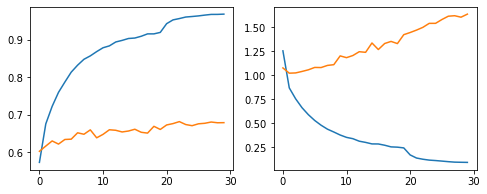

In [29]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### Finetune All
lr=1e-5

In [30]:
from keras.callbacks import ModelCheckpoint
check_point = ModelCheckpoint('VGGfaceTransfer_dropout_smoothing_keras_model', 
                              monitor='val_acc', verbose=0, save_best_only=True,
                              save_weights_only=False, mode='auto', period=1)


model.compile(optimizer = keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10,
                            callbacks=[check_point])

Epoch 1/10
789/789 [==============================] - 162s 206ms/step - loss: 0.0864 - accuracy: 0.9693 - val_loss: 1.6563 - val_accuracy: 0.6761
Epoch 2/10
789/789 [==============================] - 165s 210ms/step - loss: 0.0827 - accuracy: 0.9713 - val_loss: 1.6590 - val_accuracy: 0.6761
Epoch 3/10
789/789 [==============================] - 164s 207ms/step - loss: 0.0806 - accuracy: 0.9709 - val_loss: 1.6599 - val_accuracy: 0.6772
Epoch 4/10
789/789 [==============================] - 165s 209ms/step - loss: 0.0842 - accuracy: 0.9708 - val_loss: 1.6626 - val_accuracy: 0.6789
Epoch 5/10
789/789 [==============================] - 164s 208ms/step - loss: 0.0820 - accuracy: 0.9711 - val_loss: 1.6644 - val_accuracy: 0.6786
Epoch 6/10
789/789 [==============================] - 163s 207ms/step - loss: 0.0798 - accuracy: 0.9717 - val_loss: 1.6592 - val_accuracy: 0.6791
Epoch 7/10
789/789 [==============================] - 164s 208ms/step - loss: 0.0839 - accuracy: 0.9704 - val_loss: 1.6615 -

In [31]:
ls

__notebook_source__.ipynb  fer2013/


In [32]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist3.history[key]

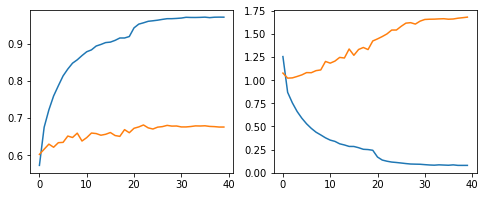

In [33]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

# model test

In [34]:
model.evaluate(test_sequence)

56/56 [==============================] - 10s 187ms/step - loss: 1.4757 - accuracy: 0.6989


[1.4757070541381836, 0.6989397406578064]

In [35]:
model.save('VGGfaceTransfer_dropout_smoothing_keras_model')

In [36]:
!tar -czvf VGGfaceTransfer_dropout_smoothing_keras_model.tar.gz VGGfaceTransfer_dropout_smoothing_keras_model

VGGfaceTransfer_dropout_smoothing_keras_model/
VGGfaceTransfer_dropout_smoothing_keras_model/assets/
VGGfaceTransfer_dropout_smoothing_keras_model/saved_model.pb
VGGfaceTransfer_dropout_smoothing_keras_model/variables/
VGGfaceTransfer_dropout_smoothing_keras_model/variables/variables.index
VGGfaceTransfer_dropout_smoothing_keras_model/variables/variables.data-00000-of-00001


In [37]:
from IPython.display import FileLink
FileLink(r'VGGfaceTransfer_dropout_smoothing_keras_model.tar.gz')

/kaggle/working/VGGfaceTransfer_dropout_smoothing_keras_model.tar.gz

### Confusion matrix

In [51]:
import tensorflow as tf
y_pred = []
y_true = []
for x,y in test_sequence:
    y_pred = y_pred + list(model.predict_classes(x))
    y_true = y_true + list(np.argmax(y,axis=1))

In [57]:
emotion_dict.values()

dict_values(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

In [58]:
emotion_dict

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [59]:
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = emotion_dict.values(), 
                                columns = emotion_dict.values())

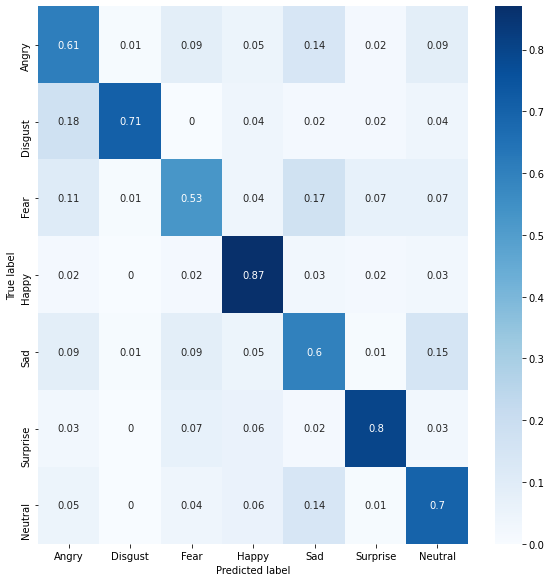

In [60]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()